### Temperature control with Deep Deterministic Policy Gradient

Based on the code of Alex Kummer PhD

#### Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
import os
import matplotlib.pyplot as plt
import timeit
import win32com.client as win32
import time
import pandas as pd

#### 1.0 Building Aspen HYSYS - Python connection 

In [2]:
class HyCase:
    def __init__(self, path):
        '''
        Connection to the HYSYS simulation case
        Defining the most important COMobjects on the flowsheet
        '''
        
        self.app = win32.Dispatch("HYSYS.Application")         #reaching Aspen HYSYS
        if path == "Active":
            self.case = self.app.ActiveDocument                #connects to active document
        else:
            file = os.path.abspath(path)
            self.case = self.app.SimulationCases.Open(file)   #connects to a specific simulation file
            
        self.file_name      = self.case.Title.Value
        self.thermo_package = self.case.Flowsheet.FluidPackage.PropertyPackageName
        self.comp_list      = np.array([i.name for i in self.case.Flowsheet.FluidPackage.Components])
        self.MatStreamList  = [i.name for i in self.case.Flowsheet.MaterialStreams]
        self.MatStreams     = self.case.Flowsheet.MaterialStreams
        self.EnerStreamList = [i.name for i in self.case.Flowsheet.EnergyStreams]
        self.OpList         = [i.name for i in self.case.Flowsheet.Operations]
        self.Ops            = self.case.Flowsheet.Operations
        self.Solver         = self.case.Solver
        self.app.CalculationTimeOut = self.app.CalculationTimeOut
        
    def set_visible(self, visibility = 1):
        """
        Determines  whether the HYSYS windom visible or not

        Args:
            visibility (int) = 0 (if invisible, default value)
            visibility (int) = 1 (if visible)
        """        
        self.case.Visible = visibility
    
    def get_stream_compositions(self):
        components = self.case.Flowsheet.FluidPackage.Components.Names
        lenght = len(components)
        names = np.array(components).reshape(lenght,1)
        stream_names = np.array(['Component names'])
        
        for stream in self.MatStreams.Names:
            ms = self.MatStreams.Item(stream)
            comp = ms.ComponentMassFractionValue
            comp = np.around(comp,4)
            frac = pd.DataFrame(comp)
            names = np.append(names,frac, axis =1)
            stream_names = np.append(stream_names, stream)
        
        np.set_printoptions(precision=4)
        stream_data = pd.DataFrame(names, columns = stream_names)
        
        print('Process streams in the simulation case:')
        print(stream_names)
        print('Number of material streams:', len(stream_names)-1)
        return stream_data
    
    def close(self):
        self.case.Close()
        self.app.quit()
        del self
    
    def save(self):
        self.case.Save()
    
    def __str__(self) -> str:
        """
        Prints the basic information about the current flowsheet.
        """        
        return f"File: {self.file_name}\n Thermodynamical package: {self.thermo_package}\n Number of components: {len(self.comp_list)}\n Number of material streams: {len(self.MatStreams)}"


class ProcessStream:
    '''
    Superclass for all process stream in the HYSYS simulation
    '''
    
    def __init__ (self, COMObject):
        self.COMObject   = COMObject
        self.connections = self.get_connections()
        self.name        = self.COMObject.name
        
    def get_connections(self) -> dict:
        """Stores the connections of the process stream into a dictionary.

        Returns:
            dict: Returns a dictionary of the upstream and downstream connections
        """        
        upstream   = [i.name for i in self.COMObject.UpstreamOpers]
        downstream = [i.name for i in self.COMObject.DownstreamOpers]
        return {"Upstream": upstream, "Downstream": downstream}


class MaterialStream(ProcessStream):
    def __init__(self, COMObject, comp_list):
        """Reads the COMObjectfrom the simulation. This class designs a material stream, which has a series
        of properties.

        Args:
            COMObject (COMObject): HYSYS COMObject.
            comp_list (list): List of components in the process stream.
        """        
        super().__init__(COMObject)
        self.comp_list   = comp_list
        self.MassFlow    = COMObject.MassFlow.GetValue('kg/h')
        self.VolFlow     = COMObject.ActualVolumeFlow.GetValue('m3/h')
        self.Temperature = COMObject.Temperature.GetValue('C')
        self.Pressure    = COMObject.Pressure.GetValue('bar_g')
        self.composition = pd.DataFrame(np.vstack(COMObject.ComponentMassFractionValue), index = comp_list, columns = ['Wt fraction'])

#### 2.0 HYSYS Environment class

In [12]:
class HYSYSEnv:
    def __init__(self, path, SP, visible = False):
        self.model            = HyCase(path)                    
        self.terminated       = False
        self.state_space_size = (3,)
        self.max_temp         = 95
        self.min_temp         = 25
        self.SP               = SP
        self.input_data       = self.model.Ops.Item('Input')
        self.Ops              = self.model.Ops
        self.MatStreams       = self.model.MatStreams
        if visible == True:
            self.model.set_visible(1)

        
    def step(self, action):
        ''' 
        Sets the inlet valve postion, then runs the integrator for a specified time, then returns the observations
        '''

        self.input_data.Cell(3,1).CellValue = action   # Spreadsheet cell connected with the actuator desired position of the cooling water inlet control valve
        temp  = self.Ops.Item('Separator').VesselTemperature()

        self.model.Solver.Integrator.RunFor(289)   # Runs the integrator for 289 seconds (~4.8 minutes - the time constant of the system)

        new_temp = self.Ops.Item('Separator').VesselTemperature()
        dt       = temp-new_temp
        inlet_t  = self.MatStreams.Item('Hot effluent').Temperature()
        inlet_v  = self.MatStreams.Item('Hot effluent').MassFlow()
        state    = [new_temp, dt, inlet_t, inlet_v]
        reward   = self.get_reward_new(new_temp)       
        done     = self.is_terminate_state(new_temp)

        self.Ops.Item('Input').Cell(1,2).CellValue = np.random.rand()*3     # Creates noise on the input effluent stream volume flow  

        return state, reward, done

        
    
    def is_terminate_state(self, state):
        '''
        Checks whether the current temperature is above the maximum allowable or below the minimum allowable temperature
        '''

        if state <= self.min_temp or state >= self.max_temp:
            return True
        else:
            return False
        
    def get_reward(self, state):
        '''
        Reward function - returns a reward based on the actual temperature
        '''
        if state >= self.max_temp or state <= self.min_temp:
            return -10
        #elif state <(0.3*self.max_level) or state > (0.8*self.max_level):
            #return 0
        elif state < (1.01*self.SP) and state > (0.99*self.SP):
            return 10
        else:
            return 0
        
    def get_reward_new(self, state):
            '''
            Parabolic reward function
            '''
            if state < (1.01*self.SP) and state > (0.99*self.SP):
                return 10
            else:
                return -(state - self.SP)**2    
        

        
    def reset(self):
        '''
        Resets the environment
        '''
        self.model.Solver.Integrator.Reset()
        state = np.zeros(4,)
        state[0] = self.Ops.Item('Separator').VesselTemperature()
        state[2] = self.MatStreams.Item('Hot effluent').Temperature()
        state[3] = self.MatStreams.Item('Hot effluent').MassFlow()
        return state
        

#### 2.1 Reaching the Aspen HYSYS file and creating the environment object

In [14]:
path = r"C:\Users\AroSomogyi\Reinforcement learingin in process control\dynamic_flash.hsc"
env = HYSYSEnv(path=path, SP= 40, visible= True)

#### 3.0 Action noise class

In [5]:
class NormalActionNoise():
    def __init__(self, mu=0, sigma=0.05):
        self.mu = mu
        self.sigma = sigma
    def __call__(self):
        noise = np.random.normal(loc=self.mu, scale=self.sigma)
        return  noise

    def exploration_decay(self):
        if self.sigma <= 0.2:
            return
        self.sigma -= 0.0025

#### 4.0 Replay buffer class

In [6]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.memory_size      = max_size
        self.memory_lenght    = 0
        self.state_memory     = np.zeros((self.memory_size, *input_shape), dtype=np.float32)
        self.new_state_memory = np.zeros((self.memory_size, *input_shape), dtype=np.float32)
        self.action_memory    = np.zeros((self.memory_size), dtype=np.float32)
        self.reward_memory    = np.zeros((self.memory_size), dtype=np.float32)
        self.terminal_memory  = np.zeros((self.memory_size), dtype=np.int64)

    def store_transition(self, state, action, reward, state_, done):
        index = self.memory_lenght % self.memory_size
        self.state_memory[index]     = state
        self.new_state_memory[index] = state_
        self.action_memory[index]    = action
        self.reward_memory[index]    = reward
        self.terminal_memory[index]  = done
        self.memory_lenght          += 1

    def sample_buffer(self, batch_size):
        max_memory = min(self.memory_lenght, self.memory_size)
        batch = np.random.choice(max_memory, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

#### 5.0 Defining Actor and critic neural networks

##### 5.1 Critic network class

In [7]:
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, hidden_layers, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir=r'C:\Users\AroSomogyi\Documents\DDPG\Hysys_environment\DDPG\New_reward_function'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + '_ddpg')
        self.hidden_layers = hidden_layers

        if self.hidden_layers == 1:
            self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)

            # Divergence from the paper
            self.bn1 = nn.LayerNorm(self.fc1_dims)

            self.action_value = nn.Linear(self.n_actions, self.fc1_dims)
            self.q = nn.Linear(self.fc1_dims, 1)
        elif self.hidden_layers == 2:
            self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
            self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

            #Divergence from the paper
            self.bn1 = nn.LayerNorm(self.fc1_dims)
            self.bn2 = nn.LayerNorm(self.fc2_dims)

            self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
            self.q = nn.Linear(self.fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta, weight_decay=0.01)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
       
        self.to(self.device)

    def forward(self, state, action):
        if self.hidden_layers == 1:
            state_value = self.fc1(state)
            state_value = self.bn1(state_value)
            state_value = F.relu(state_value)
            action_value = self.action_value(action)
            state_action_value = F.relu(T.add(state_value, action_value))
            state_action_value = self.q(state_action_value)

        elif self.hidden_layers == 2:
            state_value = self.fc1(state)
            state_value = self.bn1(state_value)
            state_value = F.relu(state_value)
            state_value = self.fc2(state_value)
            state_value = self.bn2(state_value)
            action_value = self.action_value(action)
            state_action_value = F.relu(T.add(state_value, action_value))
            state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print( '~ saving model parameters ~')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print( '~ loading model paramters ~')
        self.load_state_dict(T.load(self.checkpoint_file))


##### 5.2 Actor network

In [8]:
class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, hidden_layers, fc1_dims, fc2_dims, action_interval,
                 n_actions, name, chkpt_dir= r'C:\Users\AroSomogyi\Documents\DDPG\Hysys_environment\DDPG\New_reward_function'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + '_ddpg')
        self.hidden_layers = hidden_layers
        self.action_interval = action_interval

        if self.hidden_layers == 1:
            self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
            self.bn1 = nn.LayerNorm(self.fc1_dims)

            # batch norm: self.bn1 = nn.BatchNorm1d(self.fc1_dims), self.bn2 = nn.BatchNorm1d(self.fc2_dims)

            self.mu = nn.Linear(self.fc1_dims, self.n_actions)

        elif self.hidden_layers == 2:
            self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
            self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

            self.bn1 = nn.LayerNorm(self.fc1_dims)
            self.bn2 = nn.LayerNorm(self.fc2_dims)

            #batch norm: self.bn1 = nn.BatchNorm1d(self.fc1_dims), self.bn2 = nn.BatchNorm1d(self.fc2_dims)

            self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        # self.device = T.device('cpu')

        self.to(self.device)

    def forward(self, state):
        if self.hidden_layers == 1:
            x = self.fc1(state)
            x = self.bn1(x)
            x = F.relu(x)
            x = T.sigmoid(self.mu(x))  

        elif self.hidden_layers == 2:
            x = self.fc1(state)
            x = self.bn1(x)
            x = F.relu(x)
            x = self.fc2(x)
            x = self.bn2(x)
            x = F.relu(x)
            x = T.sigmoid(self.mu(x))

        return x

    def save_checkpoint(self):
        print('~ New optim found, saving model ~')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('~ Loading saved NN parameters ~')
        self.load_state_dict(T.load(self.checkpoint_file))

#### 6.0 DDPG agent 

In [9]:
class DDPG_Agent:
    def __init__(self, alpha, beta, input_dims, tau, n_actions, gamma=0.99,
                 max_size = 1_000_000, hidden_layers = 2, action_interval=1, fc1_dims=400, fc2_dims=300,
                 batch_size=128, name='1'):
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta
        self.name = name

        self.memory = ReplayBuffer(max_size, input_dims, n_actions)

        # self.noise = OUActionNoise(mu=np.zeros(n_actions))
        self.noise = NormalActionNoise(mu=0, sigma=0.015)

        self.actor = ActorNetwork(alpha, input_dims, hidden_layers, fc1_dims, fc2_dims, action_interval,
                                  n_actions=n_actions, name='actor_' + self.name)
        self.critic = CriticNetwork(beta, input_dims, hidden_layers, fc1_dims, fc2_dims,
                                    n_actions=n_actions, name='critic_' + self.name)
        self.target_actor = ActorNetwork(alpha, input_dims, hidden_layers, fc1_dims, fc2_dims, action_interval,
                                  n_actions=n_actions, name='target_actor_' + self.name)
        self.target_critic = CriticNetwork(beta, input_dims, hidden_layers, fc1_dims, fc2_dims,
                                    n_actions=n_actions, name='target_critic_' + self.name)

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):

        self.actor.eval() #To turn off the batchnorm layer in evaluation mode, only necessary in training mode, so it does not calculate statistics
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state).to(self.actor.device)
        #Exploration:


        mu_prime = mu + T.tensor(self.noise(), dtype=T.float).to(self.actor.device)


        # mu_prime = mu
        self.actor.train() # to turn on the batchnorm layer in training mode
        return mu_prime.cpu().detach().numpy()[0]
    
    def action_mapper(self, action):
        action_value = action * 100
        return action_value


    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()


    def learn(self):
        if self.memory.memory_lenght < self.batch_size:
            return

        states, actions, rewards, states_, done = self.memory.sample_buffer(self.batch_size)

        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        actions = actions.view(self.batch_size,1)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)

        target_actions = self.target_actor.forward(states_)
        critic_value_ = self.target_critic.forward(states_, target_actions) #Q value of the next evaluation - critic
        critic_value = self.critic.forward(states, actions) #actual prediction of Q-value - critic

        critic_value_[done] = 0.0
        critic_value_ = critic_value_.view(-1)

        target = rewards + self.gamma*critic_value_ #y_i   # target value
        target = target.view(self.batch_size, 1)

        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.actor.optimizer.zero_grad()
        actor_loss = -self.critic.forward(states, self.actor.forward(states)) #Q values in states based on the critic network
        actor_loss = T.mean(actor_loss) #Average loss function
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None): #soft-update
        if tau is None:
            tau = self.tau
        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_state_dict = dict(target_critic_params)
        target_actor_state_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                      (1-tau)*target_critic_state_dict[name].clone()

        for name in actor_state_dict:
            actor_state_dict[name] = tau * actor_state_dict[name].clone() + \
                                      (1 - tau) * target_actor_state_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)


#### 7.0 DDPG agent training

Time:  46.12530620000325
episode 0 score:  40 average score 40.0 best score -inf
~ New optim found, saving model ~
~ New optim found, saving model ~
~ saving model parameters ~
~ saving model parameters ~
Time:  60.06622960000095
episode 1 score:  80 average score 60.0 best score 40.0
~ New optim found, saving model ~
~ New optim found, saving model ~
~ saving model parameters ~
~ saving model parameters ~
Time:  62.0292300000001
episode 2 score:  310 average score 143.3 best score 60.0
~ New optim found, saving model ~
~ New optim found, saving model ~
~ saving model parameters ~
~ saving model parameters ~
Time:  61.238369800004875
episode 3 score:  1180 average score 402.5 best score 143.3
~ New optim found, saving model ~
~ New optim found, saving model ~
~ saving model parameters ~
~ saving model parameters ~
Time:  56.60887340000045
episode 4 score:  40 average score 330.0 best score 402.5
Time:  57.384955499997886
episode 5 score:  0 average score 275.0 best score 402.5
Time:  6

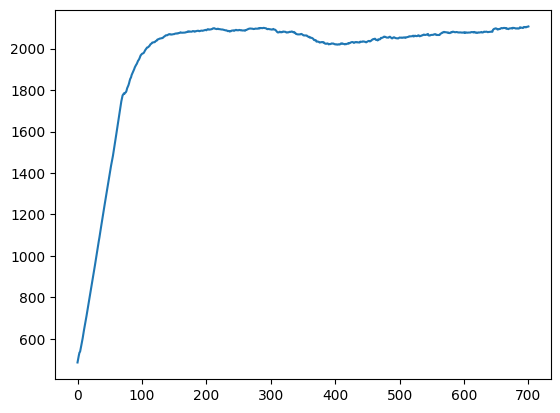

In [111]:
path = r"C:\Users\AroSomogyi\Reinforcement learingin in process control\dynamic_flash.hsc"
env = HYSYSEnv(path=path, SP= 40, visible= True)

agent = DDPG_Agent(alpha=0.000025, beta=0.00025, input_dims=(4,),
                   tau = 0.005, n_actions=1, gamma=0.99, max_size=100_000, hidden_layers=2, action_interval=1,
                   fc1_dims=64, fc2_dims=256, batch_size=64, name='HYSYS_DDPG_1_64')

best_score = -np.inf
n_cases = 800
load_checkpoint = False
h0 = 0
max_iterations = 300
n_steps = 0

res = 100
score_history , action_list = [], []

for i in range(n_cases):
    done = False
    score = 0
    observation = env.reset()
    iterations = 0
    start = timeit.default_timer()
    
    while not done:

        action = agent.choose_action(observation)
        observation_, reward, done = env.step(action[0])
        score += reward
        action_list.append(action)

        if not load_checkpoint:
            agent.remember(observation, action, reward, observation_, int(done))
            
            agent.learn()

        observation = observation_
        
            
        iterations +=1
        if iterations >= max_iterations:
            break

    stop = timeit.default_timer()
    print('Time: ', stop - start)

    score_history.append(score)

    avg_score = np.mean(score_history[-res:])
    print('episode', i, 'score: ', score,
          'average score %.1f best score %.1f' %
          (avg_score, best_score)
          )

    if avg_score > best_score:
        if not load_checkpoint:
            agent.save_models()
        best_score = avg_score

moving_avg = np.convolve(score_history, np.ones((res,)) / res,
                                 mode='valid')
plt.plot(range(len(moving_avg)),moving_avg)

#### Training scores

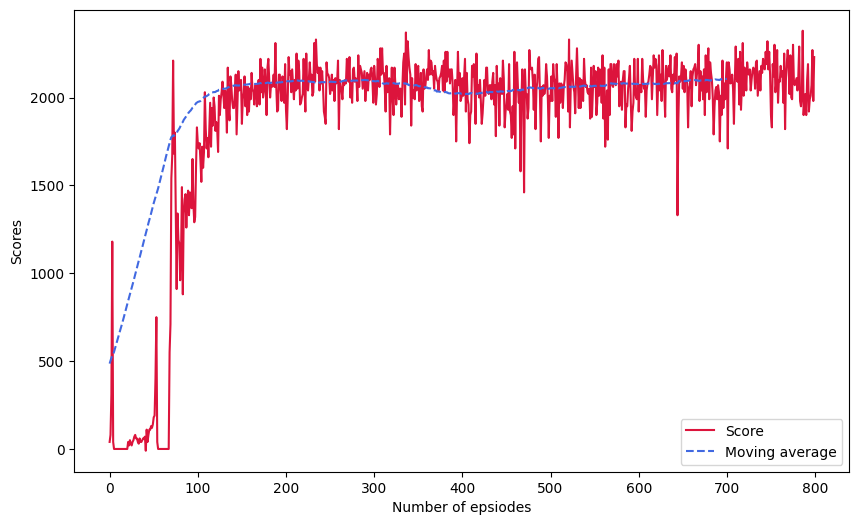

In [118]:
moving_avg = np.convolve(score_history, np.ones((res,)) / res,
                                 mode='valid')
plt.figure(figsize=(10,6))

plt.plot(range(len(score_history)),score_history, color = 'crimson', label = 'Score')
plt.plot(range(len(moving_avg)),moving_avg, color = 'royalblue', linewidth = 1.5, label = 'Moving average', linestyle = '--')
plt.ylabel('Scores')
plt.xlabel('Number of epsiodes')
plt.legend()

Text(0, 0.5, 'Score')

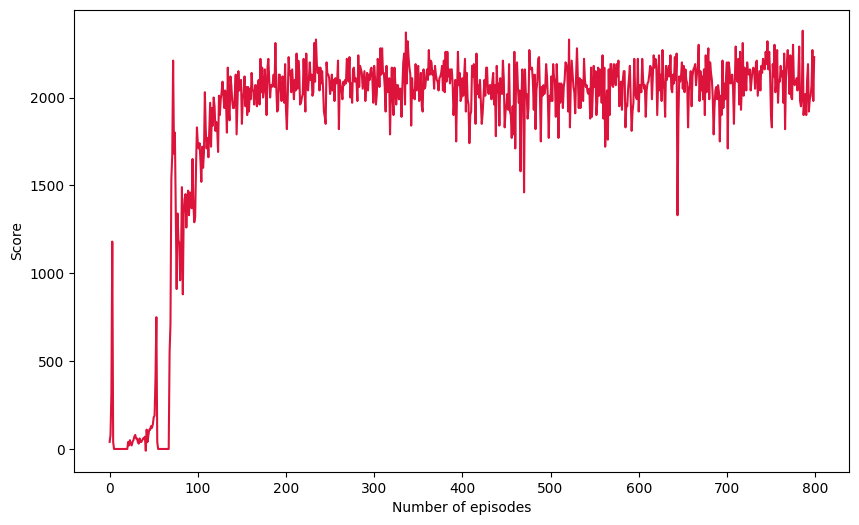

In [115]:
plt.figure(figsize=(10,6))

moving_avg = np.convolve(score_history, np.ones((res,)) / res, mode='valid')
plt.plot(range(len(score_history)),score_history, color = 'crimson')
plt.xlabel('Number of episodes')
plt.ylabel('Score')

#### 8.0 Evaulation of the trained agent

In [ ]:
path = r"C:\Users\AroSomogyi\Reinforcement learingin in process control\dynamic_flash.hsc"
env = HYSYSEnv(path=path, SP= 40, visible= True)

agent = DDPG_Agent(alpha=0.000025, beta=0.00025, input_dims=(4,),
                   tau = 0.005, n_actions=1, gamma=0.99, max_size=100_000, hidden_layers=2, action_interval=1,
                   fc1_dims=256, fc2_dims=256, batch_size=64, name='HYSYS_DDPG')

best_score = -np.inf
n_cases = 1
load_checkpoint = True
max_iterations = 1000
n_steps = 0

res = 100
score_history , action_list = [], []

for i in range(n_cases):
    done = False
    score = 0
    observation = env.reset()
    iterations = 0
    start = timeit.default_timer()
    
    while not done:

        action = agent.choose_action(observation)
        observation_, reward, done = env.step(action[0])
        score += reward
        action_list.append(action)
       

        if not load_checkpoint:
            agent.remember(observation, action, reward, observation_, int(done))
            
            agent.learn()

        observation = observation_
            
        iterations +=1
        if iterations >= max_iterations:
            break

    stop = timeit.default_timer()
    print('Time: ', stop - start)

    score_history.append(score)

    avg_score = np.mean(score_history[-res:])
    print('episode', i, 'score: ', score,
          'average score %.1f best score %.1f' %
          (avg_score, best_score)
          )

    if avg_score > best_score:
        if not load_checkpoint:
            agent.save_models()
        best_score = avg_score

moving_avg = np.convolve(score_history, np.ones((res,)) / res,
                                 mode='valid')
plt.plot(range(len(moving_avg)),moving_avg)

moving_avg2 = np.convolve(score_history, np.ones((res,)) / res,
                                 mode='valid')
plt.plot(range(len(moving_avg2)),moving_avg2)

#### Reward function

In [24]:
env = HYSYSEnv(path=path, SP= 40, visible= True)
s_max = 90
s_min = 30
SP = 40

states = np.linspace(20,100,1000)
rewards=[]

for state in states:
    rew = env.get_reward(state=state)
    rewards.append(rew)
  

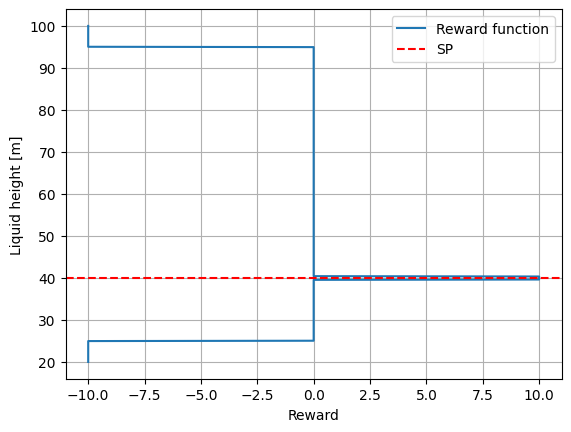

In [26]:
plt.plot(rewards, states, label ='Reward function')
plt.axhline(40, color = 'red', linestyle = '--', label ='SP')
plt.ylabel('Liquid height [m]')
plt.xlabel('Reward')
plt.legend()
plt.grid()